# 2D SSN Model

In this notebook:
- training script for SSN model
- implementation of vmap
- new parameter added for extra synaptic GABA
- storing accuracy and params in csv file
- function to plot csv file data

GPU jax issues
- https://github.com/google/jax/issues/5231
- https://catid.io/posts/jax/

Imports

In [1]:
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax
from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
import csv
import time
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy

from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))
#config.update('jax_debug_nans', True)
from SSN_classes_jax import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating, find_A, create_gabor_filters, create_gratings

#initialize key
key = random.PRNGKey(9)

jax backend cpu


In [2]:
from platform import python_version
print(python_version())

3.8.10


### Parameters to define

1. STIMULI PARAMETERS

In [3]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55
offset = 5

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 15, jitter_val = 5)
stimuli_pars.update(general_pars)

2. MODEL PARAMETERS

In [127]:
#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
#sigEI, sigII = .2, .2
conn_pars = dict(
    PERIODIC = False,
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Parameters exclusive to Gabor filters
filter_pars = dict(sigma_g = sigma_g, conv_factor = grid_pars.magnif_factor)
filter_pars.update(general_pars) 


#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)


#Excitatory and inhibitory constants for extra synaptic GABA
ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
c_E = 5.0
c_I = 5.0

#Sigmoid parameters
N_neurons = 25

#key, _ = random.split(key)
#w_sig = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
w_sig = numpy.random.normal(size=(N_neurons,)) / np.sqrt(N_neurons)
#w_sig = np.zeros((N_neurons))
b_sig = 0.0

#Optimization pars
opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)

#Convergence parameters
conv_pars=dict(dt = 1, xtol = 1e-5, Tmax = 400, verbose=False, silent=True)
w_sig

DeviceArray([-0.22677548,  0.14835903,  0.23774771, -0.2809642 ,
             -0.2382864 ,  0.02087653,  0.03211895,  0.02203457,
             -0.32399544, -0.155516  , -0.04755862, -0.10674761,
             -0.15507194,  0.0880091 , -0.31969675,  0.26859832,
              0.14288603,  0.07046083,  0.00828944, -0.09122247,
              0.11211646,  0.17740835, -0.0380225 ,  0.01610596,
             -0.24633582], dtype=float32)

3. TRAINING PARAMETERS

In [87]:
#Name of results csv
home_dir = os.getcwd()
#Create directory for results
results_dir = os.path.join(home_dir, 'results')
if os.path.exists(results_dir) == False:
        os.makedirs(results_dir)
        
        
results_name = 'test_batch.csv' #SPECIFY NAME OF RESULTS FILE
if results_name == None:
    results_name = 'results.csv'

results_filename = os.path.join(results_dir, results_name)

#Number of epochs
epochs = 100
num_epochs_to_save = 21
epochs_to_save = np.linspace(1 ,epochs, num_epochs_to_save).astype(int)


## TRAINING

In [128]:
def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and noise value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data


def save_params_dict(opt_pars, accuracy, epoch ):
    J_2x2, s_2x2 = exponentiate(opt_pars)
     
    save_params= dict(val_accuracy= accuracy, 
                J_EE= J_2x2[0,0], J_EI = J_2x2[0,1], 
                              J_IE = J_2x2[1,0], J_II = J_2x2[1,1], 
                s_EE= s_2x2[0,0], s_EI = s_2x2[0,1], 
                              s_IE = s_2x2[1,0], s_II = s_2x2[1,1],
                c_E = opt_pars['c_E'], c_I = opt_pars['c_I'], 
                 epoch = epoch, w_sig = opt_pars['w_sig'], b_sig=opt_pars['b_sig'])
    
    return save_params

def constant_to_vec(c_E, c_I):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_E, vec_I, vec_I))
    return constant_vec

def sigmoid(x):
    return 1/(1+np.exp(x))

def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def exponentiate(opt_pars):
    signs=np.array([[1, -1], [1, -1]]) 
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    return J_2x2, s_2x2

def our_max(x, beta=1):
    max_val = np.log(np.sum(np.exp(x*beta)))/beta
    return max_val

def model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, Rmax_E = 50, Rmax_I = 100, lam_1=1, lam_2=1):
    
    J_2x2, s_2x2 = exponentiate(opt_pars)
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(opt_pars['c_E'], opt_pars['c_I'])
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])
    
    #Find fixed point response + select centre neurons
    fp_ref, _, avg_dx_ref = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)
    r_max_ref = np.maximum(0, (our_max(fp_ref[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp_ref[ssn.Ne:-1])/Rmax_I - 1))
    
    fp_target, _, avg_dx_target = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)
    r_max_target = our_max(fp_target[:ssn.Ne])/Rmax_E  + our_max(fp_target[ssn.Ne:-1])/Rmax_I

    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + opt_pars['b_sig'])

    #Calculate binary cross entropy loss
    loss=binary_loss(train_data['label'], x)
    
    #Combine loss with maximum rate and dx value
    mag=np.abs(loss)
    loss = loss + (lam_1*(avg_dx_ref + avg_dx_target)/2 + lam_2*(r_max_ref + r_max_target)/2)*mag
   
    return loss


def loss(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars):
    '''
    Calculate parallelized loss for batch of data through vmap.
    Output:
        mean loss of all the input images
    '''
    
    vmap_model = vmap(model, in_axes = ({'b_sig': None, 'c_E':None, 'c_I': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )                   
    loss = np.sum(vmap_model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars))

    return loss




def eval_model(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    
    J_2x2, s_2x2 = exponentiate(opt_pars)
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(opt_pars['c_E'], opt_pars['c_I'])
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)

    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, test_data['ref']) + constant_vector
    
    output_target=np.matmul(ssn.gabor_filters, test_data['target']) + constant_vector

    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])

    fp_ref, _, avg_dx_ref = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)

    fp_target, _, avg_dx_target = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)
    
    dot= np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel()))

    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + opt_pars['b_sig'])
    
    #compare prediction to label
    pred_label = np.round(x)

    #Calculate binary cross entropy loss
    loss=binary_loss(test_data['label'], x)
    
    return loss, pred_label, x


def vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    
    eval_vmap = vmap(eval_model, in_axes = ({'b_sig': None,  'c_E':None, 'c_I': None,  'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    losses, pred_labels, dots = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    
    accuracy = np.sum(test_data['label'] == pred_labels)/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    
    return vmap_loss, accuracy, dots


def train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars, conv_pars, epochs_to_save, results_filename = None, batch_size=20, ref_ori = 55, offset = 5, epochs=1, eta=10e-4):
    
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
    
        
    #Initialise optimizer
    optimizer = optax.adam(eta)
    opt_state = optimizer.init(opt_pars)
    
    #Define test data - no need to iterate
    test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)
    val_loss, accuracy, _= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    print('Before training  -- loss: {}, accuracy: {} '.format(val_loss, accuracy))
    val_loss_per_epoch.append(val_loss)
    
    #Save initial parameters
    save_params = save_params_dict(opt_pars=opt_pars, accuracy=accuracy, epoch=0 )
    
    #Initialise csv file
    if results_filename:
        #AVOID OVERWRITING FILES? 
        results_handle = open(results_filename, 'w')
        results_writer=None
        results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
        results_writer.writeheader()
        results_writer.writerow(save_params)
        print('Saving results to csv ', results_filename)
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        epoch_loss = 0 
           
        #load next batch of data and convert
        train_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

        #Compute loss and gradient
        epoch_loss, grad =jax.value_and_grad(loss)(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)

        #Apply SGD through Adam optimizer per batch
        updates, opt_state = optimizer.update(grad, opt_state)
        opt_pars = optax.apply_updates(opt_pars, updates)
        training_losses.append(epoch_loss)
        
        epoch_time = time.time() - start_time

        #Save the parameters given a number of epochs
        if epoch in epochs_to_save:
            
            #Evaluate model 
            test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)
            val_loss, accuracy, _= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
            print('Training loss: {} ¦ Validation -- loss: {}, accuracy: {} at epoch {}, (time {})'.format(epoch_loss, val_loss, accuracy, epoch, epoch_time))
            val_loss_per_epoch.append(val_loss)
            
            #Create dictionary of parameters to save
            save_params = save_params_dict(opt_pars, accuracy, epoch)
            
            #Write results in csv file
            if results_filename:
                results_writer.writerow(save_params)

    #Reparametize parameters
    signs=np.array([[1, -1], [1, -1]])    
    opt_pars['logJ_2x2'] = np.exp(opt_pars['logJ_2x2'])*signs
    opt_pars['logs_2x2'] = np.exp(opt_pars['logs_2x2'])
    
   
    return opt_pars, val_loss_per_epoch, training_losses

In [117]:
results_batch50 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/BATCH_50.csv'
#final_pars_test, val_loss_test, training_los_test= train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, epochs_to_save = epochs_to_save, results_filename=results_filename, ref_ori = 55, offset = 2, batch_size = 50, epochs = epochs)

In [130]:
results_batch100_offset10 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/BATCH_100_offset10.csv' # RUN FOR 0.5 DEGREE OFFSET
final_pars_test, val_loss_test, training_los_test= train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, epochs_to_save = epochs_to_save, results_filename=results_batch100_offset10, ref_ori = 55, offset = 10, batch_size = 100, epochs = epochs)

Before training  -- loss: 0.8178649544715881, accuracy: 0.3499999940395355 
Saving results to csv  /mnt/d/temp/ssn_modelling/ssn-simulator/results/BATCH_100_offset10.csv
Training loss: 2139.25146484375 ¦ Validation -- loss: 0.8846997022628784, accuracy: 0.23999999463558197 at epoch 1, (time 14.520220279693604)
Training loss: 1484.0546875 ¦ Validation -- loss: 0.8026805520057678, accuracy: 0.28999999165534973 at epoch 5, (time 14.429353952407837)
Training loss: 1222.26904296875 ¦ Validation -- loss: 0.7644760012626648, accuracy: 0.3700000047683716 at epoch 10, (time 14.015573024749756)
Training loss: 912.8980712890625 ¦ Validation -- loss: 0.7287132143974304, accuracy: 0.3700000047683716 at epoch 15, (time 14.311463356018066)
Training loss: 783.626953125 ¦ Validation -- loss: 0.6711982488632202, accuracy: 0.5099999904632568 at epoch 20, (time 14.347245931625366)
Training loss: 774.1375732421875 ¦ Validation -- loss: 0.6819279193878174, accuracy: 0.49000000953674316 at epoch 25, (time 14

## INITIALIZATION HISTOGRAM

In [ ]:
from util import initial_acc
all_acc, low_acc = initial_acc( opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_max = 5,  std_max = 80)

## PLOT RESULTS

In [34]:
def plot_results(results_file, title=None):
    
    results = pd.read_csv(results_file, header = 0)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

    results.plot(x='epoch', y=["J_EE", "J_EI", "J_IE", "J_II"], ax=axes[0,0])
    results.plot(x='epoch', y=["s_EE", "s_EI", "s_IE", "s_II"], ax = axes[0,1])
    results.plot(x='epoch', y=["c_E", "c_I"], ax = axes[1,0])
    results.plot(x='epoch', y = 'val_accuracy', ax = axes[1,1])
    
    if title:
        fig.suptitle(title)
    fig.show()

In [33]:
def param_ratios(results_file):
    results = pd.read_csv(results_file, header = 0)
    res = results.to_numpy()
    Js=res[:,1:5]
    ss = res[:,5:9]
    #print(Js.type())
    print(results.columns[1:5])
    print("J ratios = ", np.array((Js[-1,:]/Js[0,:] -1)*100, dtype=int))
    print(results.columns[5:9])
    print(ss[-1,:]/ss[0,:])
    print("s ratios = ", np.array((ss[-1,:]/ss[0,:] -1)*100, dtype=int))

In [13]:
results_filename = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/constant_set_5.csv'
results_filename2 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/constant_set_0.csv'
results_filename3 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/constant_set_0_Tmax200.csv'
results_filename4 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/constant_set_5_Tmax200.csv'
results_new_loss='/mnt/d/temp/ssn_modelling/ssn-simulator/results/test_new_loss.csv'
results_batch50 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/batch50_c_5_T400.csv'
new_results = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/batch50_c_0_T200.csv'

In [131]:
param_ratios(results_batch100_offset10)

Index(['J_EE', 'J_EI', 'J_IE', 'J_II'], dtype='object')
J ratios =  [-4  4  4 -3]
Index(['s_EE', 's_EI', 's_IE', 's_II'], dtype='object')
[1.0497657524882877 1.0 0.95957785 1.0]
s ratios =  [ 4  0 -4  0]


In [118]:
param_ratios(results_filename)

Index(['J_EE', 'J_EI', 'J_IE', 'J_II'], dtype='object')
J ratios =  [-5  5  5 -3]
Index(['s_EE', 's_EI', 's_IE', 's_II'], dtype='object')
[1.0489922024496101 1.0 0.96165925 1.0]
s ratios =  [ 4  0 -3  0]


In [123]:
param_ratios(results_filename) # BATCH 100, oFFSET = 10

Index(['J_EE', 'J_EI', 'J_IE', 'J_II'], dtype='object')
J ratios =  [-4  4  4 -2]
Index(['s_EE', 's_EI', 's_IE', 's_II'], dtype='object')
[1.0499887024994352 1.0 0.9577154999999999 1.0]
s ratios =  [ 4  0 -4  0]


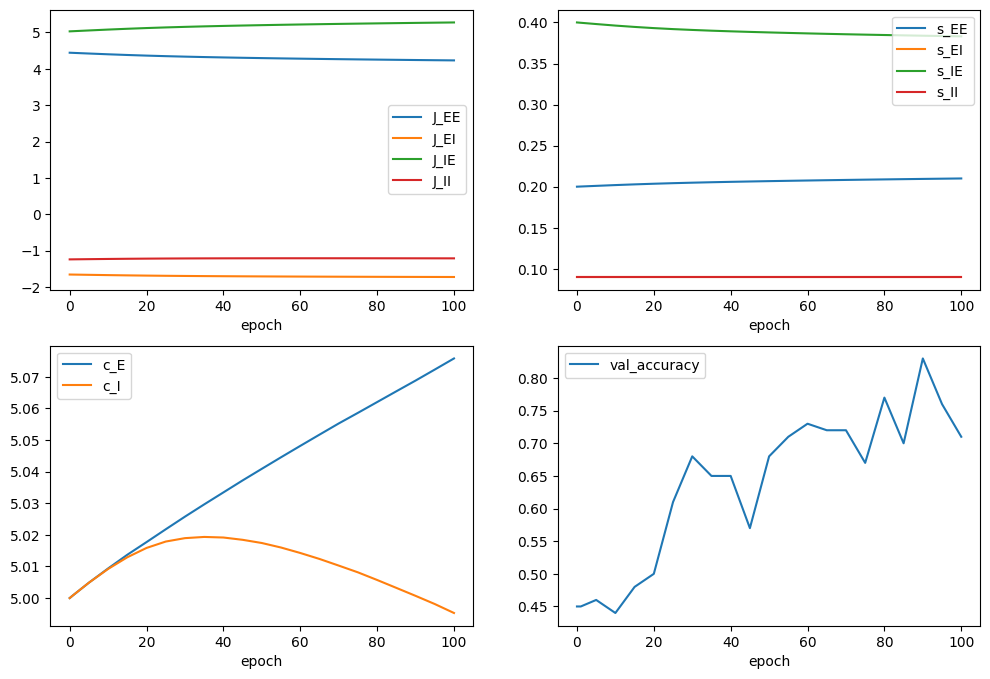

In [124]:
plot_results(results_filename)

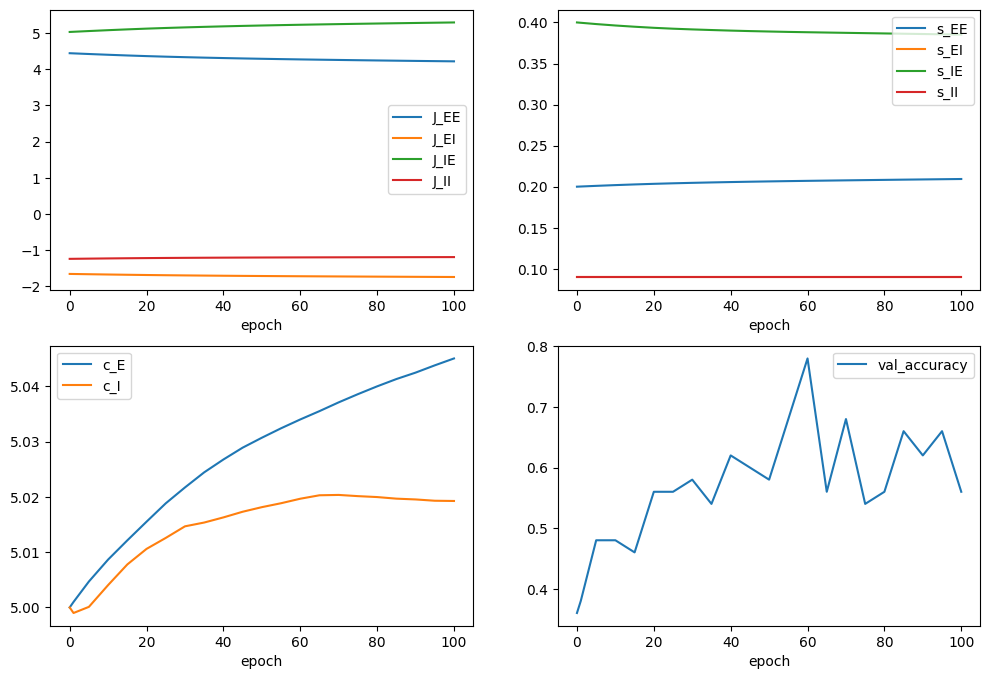

In [121]:
plot_results(results_batch50)

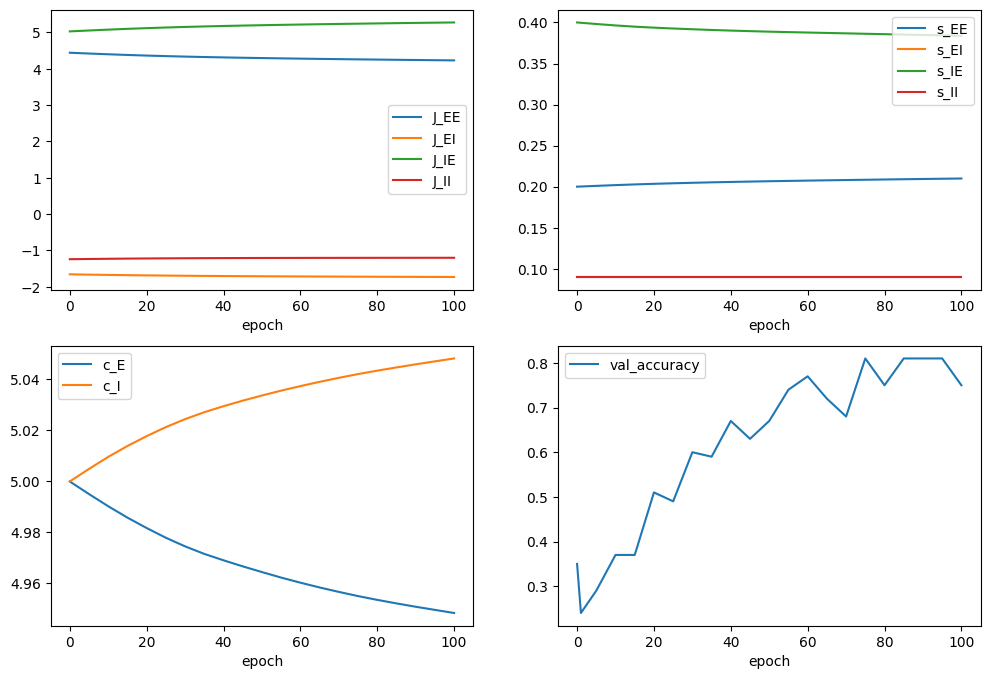

In [132]:
plot_results(results_batch100_offset10)

## Proof of concept model

In [ ]:
def make_log_J_2x2(Js0):
    make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
    J_2x2 = make_J2x2(*Js0)
    signs=np.array([[1, -1], [1, -1]])
    logJ_2x2 =np.log(J_2x2*signs)
    
    return logJ_2x2

In [ ]:
def create_new_pars(o_Js0, position, value, params):
    
    Js0 = o_Js0.copy()
    Js0[position] = Js0[position]*value
    #print(Js0[position])
    updated_params = params.copy()
    logJ_2x2 = make_log_J_2x2(Js0)
    updated_params['logJ_2x2'] = logJ_2x2
    
    return updated_params

1. Create results file

In [ ]:
#Name of results csv
home_dir = os.getcwd()
#Create directory for results
results_dir = os.path.join(home_dir, 'results')
if os.path.exists(results_dir) == False:
        os.makedirs(results_dir)
        
        
results_name = 'proof.csv' #SPECIFY NAME OF RESULTS FILE
if results_name == None:
    results_name = 'results_test2.csv'

results_filename = os.path.join(results_dir, results_name)
results_handle = open(results_filename, 'w')

#results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
#results_writer.writeheader()

In [ ]:
def save_params(new_pars, test_accuracy, results_handle, header=False):
    save_params= dict(val_accuracy= test_accuracy, 
    J_EE= new_pars['logJ_2x2'][0,0], J_EI = new_pars['logJ_2x2'][0,1], 
                  J_IE = new_pars['logJ_2x2'][1,0], J_II = new_pars['logJ_2x2'][1,1])
    
    if header==True:
        results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
        results_writer.writeheader()
    
    
    results_writer.writerow(save_params)       

1. Redefine parameters

In [ ]:
# Caleb's params for the full (with local) model:
o_Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*o_Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)


#Optimization pars
opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)
opt_pars['logJ_2x2']

2. Generate testing data

In [ ]:
ref_ori = 55
offset = 10
batch_size = 200
test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

3. Evaluate original model

In [ ]:
_, test_accuracy, _ = vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
test_accuracy

--> Edit parameters

J_EE

In [ ]:
new_pars = create_new_pars(o_Js0, 0, 0.8, opt_pars)
_, test_accuracy, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy)

#save_params(new_pars, test_accuracy, results_handle, header = True)
new_pars = create_new_pars(o_Js0, 0, 1.2, opt_pars)
_, test_accuracy, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy)

J_EI

In [ ]:
new_pars = create_new_pars(o_Js0, 1, 0.8, opt_pars)
_, test_accuracy_1, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_1)

new_pars = create_new_pars(o_Js0, 1, 1.2, opt_pars)
_, test_accuracy_2, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_2)

J_IE

In [ ]:
new_pars = create_new_pars(o_Js0, 2, 0.8, opt_pars)
_, test_accuracy_1, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_1)

new_pars = create_new_pars(o_Js0, 2, 1.2, opt_pars)
_, test_accuracy_2, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_2)

J_II

In [ ]:
new_pars = create_new_pars(o_Js0, 3, 0.8, opt_pars)
_, test_accuracy_1, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_1)

new_pars = create_new_pars(o_Js0, 3, 1.2, opt_pars)
_, test_accuracy_2, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_2)